In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point
import copy

In [37]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [38]:
geodata['centroid'] = geodata.centroid

In [111]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
357,W06000001,Isle of Anglesey,"POLYGON ((240000.004 394577.908, 240445.514 39...",1,POINT (241835.228 379233.676)
358,W06000002,Gwynedd,"MULTIPOLYGON (((267978.708 372366.304, 270868....",1,POINT (264136.399 334667.737)
359,W06000003,Conwy,"POLYGON ((299724.870 380889.607, 300371.113 37...",1,POINT (284072.324 361552.108)
360,W06000004,Denbighshire,"POLYGON ((324414.214 353387.707, 323145.711 35...",1,POINT (309507.880 355562.623)
361,W06000005,Flintshire,"MULTIPOLYGON (((313293.515 382786.601, 315287....",1,POINT (322547.437 368615.133)
362,W06000006,Wrexham,"POLYGON ((351298.712 343127.004, 350716.010 34...",1,POINT (331695.185 344175.768)
363,W06000008,Ceredigion,"POLYGON ((279749.210 249226.602, 277768.013 24...",1,POINT (258559.569 263733.729)
364,W06000009,Pembrokeshire,"MULTIPOLYGON (((216364.016 243983.404, 217396....",1,POINT (201337.424 221180.436)
365,W06000010,Carmarthenshire,"POLYGON ((279749.210 249226.602, 282307.116 24...",1,POINT (251556.904 225139.754)
366,W06000011,Swansea,"MULTIPOLYGON (((262123.115 210278.302, 264479....",1,POINT (258170.595 195828.191)


<AxesSubplot:>

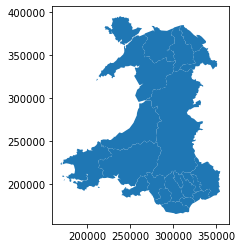

In [41]:
geodata.plot()

In [42]:
neighbours = geodata.sjoin(geodata, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

In [43]:
def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

neighbours['target_angle'] = neighbours.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'target_angle']]

In [44]:
neighbours

,LAD20CD_left,LAD20CD_right,target_angle
358,W06000002,W06000004,0.431575
359,W06000003,W06000004,-0.231264
361,W06000005,W06000004,-2.355698
362,W06000006,W06000004,2.667429
377,W06000023,W06000004,1.505988
...,...,...,...
377,W06000023,W06000019,-1.354165
373,W06000019,W06000021,-0.017100
374,W06000020,W06000021,0.527129
376,W06000022,W06000021,1.255565


In [45]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['centroid_left'].distance(row['centroid_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [46]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,2.0,-1.106822
2,W06000001,W06000003,1.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,5.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,2.0,0.220886
479,W06000024,W06000020,4.0,-0.237013
480,W06000024,W06000021,10.0,0.065829
481,W06000024,W06000022,8.0,-0.597980


In [47]:
# Create an initial grid

initial_scale_factor = 2

full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])
initial_y_length = int(np.round(initial_scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
initial_x_length = int(np.round(axis_ratio*initial_y_length))

initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
initial_grid_size = initial_y_length*initial_x_length

In [147]:
neighbour_distance_factor = 10
neighbour_angle_factor = 1

proximity_distance_factor = 10
proximity_angle_factor = 2

packing_factor = 2

max_move_jump = 1


def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def get_metric(it_gdf):
    
    # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'target_angle']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left').fillna(0)
    
    
    # Define the proximity metric
    it_prox = it_gdf.merge(distance_ranking, left_on='code', right_on='LAD20CD_left')
    it_prox = it_prox.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_prox = it_prox[['code', 'geometry', 'code_r', 'geometry_r', 'target_distance_rank', 'target_angle']]
    
    it_prox['distance'] = it_prox.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_prox['distance_rank'] = it_prox.groupby('code')['distance'].rank()
    it_prox['distance_rank_difference'] = it_prox['distance_rank']-it_prox['target_distance_rank']
    it_prox['angle'] = it_prox.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_prox['angle_diff'] = it_prox.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)
    
    it_prox['proximity_metric'] = it_prox.apply(lambda row: (proximity_distance_factor*row['distance_rank_difference']**2)+(proximity_angle_factor*row['angle_diff']**2), axis=1)
    proximity_metric = it_prox.groupby('code')['proximity_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(proximity_metric, on='code', how='left').fillna(0)
    
    
    # Define the packing metric
    it_pack = copy.copy(it_gdf)
    it_pack['dummy'] = [1]*len(it_pack)
    it_pack = it_pack.merge(it_pack, how='inner', on='dummy', suffixes=('', '_r'))
    it_pack['distance'] = it_pack.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_pack['packing_metric'] = it_pack.apply(lambda row: packing_factor*row['distance']**2, axis=1)
    packing_metric = it_pack.groupby('code')['packing_metric'].sum().reset_index()
    it_gdf = it_gdf.merge(packing_metric, on='code', how='left').fillna(0)
    
    it_gdf['metric'] = it_gdf['neighbour_metric']+it_gdf['proximity_metric']+it_gdf['packing_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def do_swaps(gdf, max_metric):
    
#     max_metric = gdf[gdf['metric']==gdf['metric'].max()]
    original_metric = gdf['metric'].sum()
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
#     for x_shift, EW in zip([-1,0,1], ['W', 'C', 'E']):
#         for y_shift, NS in zip([-1,0,1], ['S', 'C', 'N']):
#             directions.append(NS+EW)
    for x_shift in range(-max_move_jump, max_move_jump+1):
        for y_shift in range(-max_move_jump, max_move_jump+1):
            directions.append((x_shift, y_shift))
            new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
            
            new_df = copy.copy(gdf)
            new_df.loc[(gdf['geometry']==new_loc), 'geometry'] = original_loc
            new_df.loc[(gdf['geometry']==original_loc), 'geometry'] = new_loc
            
            metric_columns = [c for c in new_df.columns if 'metric' in c]
            new_df = get_metric(new_df.drop(columns=metric_columns))
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)] if np.min(metrics) < original_metric else (0,0)
    output_df = new_dfs[np.argmin(metrics)] if np.min(metrics) < original_metric else gdf
    return dir_to_use, new_dfs[np.argmin(metrics)]


def do_iteration(gdf_in):
    
    # THIS IS WHERE I'M WORKING
    # I need to run do_swaps on the dataframe.
    # If there's no change (i.e. d=="CC") then I need to set that row's is_tested to True and run do_swaps again.
    # If I can keep running do_swaps until there's nothing left that can be swapped, we stop.
    
    gdf = copy.copy(gdf_in)
    gdf['is_tested'] = [False]*len(gdf)
    
    all_tested = False    
    iterate = True
    
    old_gdf = copy.copy(gdf)
    while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[(old_gdf['metric']==max_metric) & (old_gdf['is_tested']==False)]
        d, new_gdf = do_swaps(old_gdf, row_to_test)        
        
        if d != (0,0):
            iterate = False
            
        else:
            new_gdf.loc[(new_gdf['metric']==max_metric) & (new_gdf['is_tested']==False), 'is_tested'] = True
            num_tested = new_gdf['is_tested'].sum()
            all_tested = True if num_tested == len(new_gdf) else False
            iterate = True if num_tested < len(new_gdf) else False
            old_gdf = copy.copy(new_gdf)
            
    return all_tested, new_gdf.drop(columns=['is_tested'])

In [148]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values

num_initialisations = 20
initial_dfs = {}
initial_metrics = []
for random_seed in range(num_initialisations):
    initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))
    initial_dfs[random_seed] = find_it_gdf(codes_list, initial_coords)
    initial_metrics.append(initial_dfs[random_seed]['metric'].sum())
    
initial_df = initial_dfs[np.argmin(initial_metrics)]

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

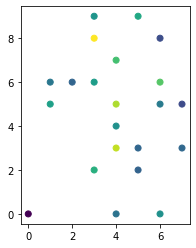

it 0:  -6704.099495408882


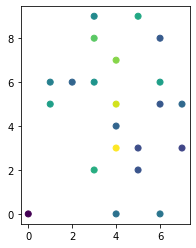

it 1:  -8537.283573562163


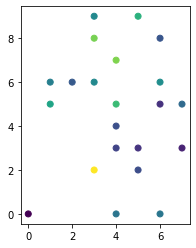

it 2:  -14367.655822308501


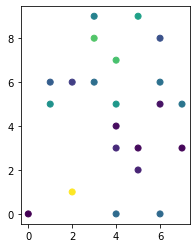

it 3:  -8285.025756774878


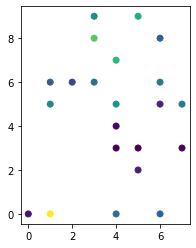

it 4:  -6645.149783465604


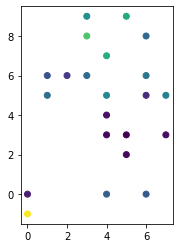

it 5:  -4620.449400853657


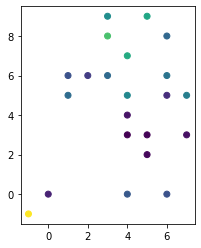

it 6:  -673.753346958023


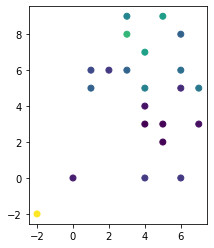

it 7:  -790.5708685983554


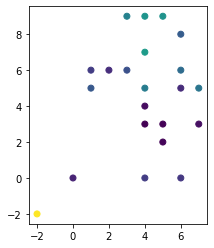

it 8:  -5566.98164968635


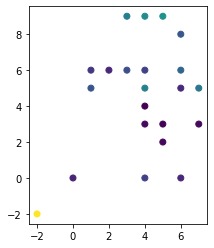

it 9:  -4681.160858524963


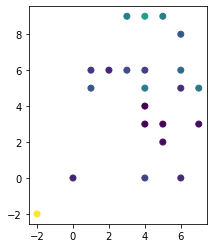

it 10:  -1201.0292929032585


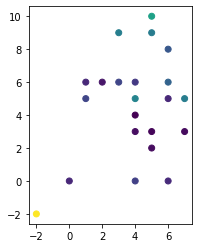

it 11:  -1578.0862860474153


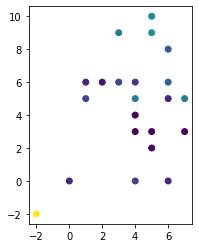

it 12:  -3222.6779112638906


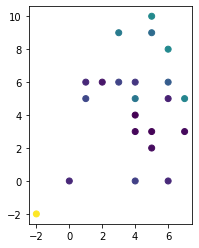

it 13:  -574.6347166557098


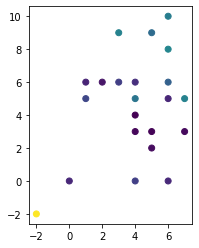

it 14:  -997.2981017017737


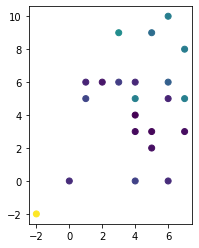

it 15:  -740.9175806933781


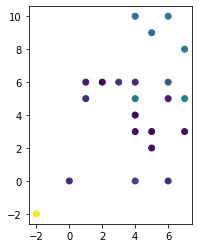

it 16:  -5372.376015654765


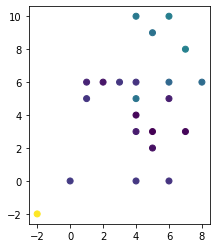

it 17:  -14584.578008253826


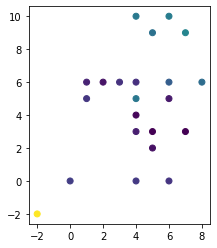

it 18:  -242.20041880753706


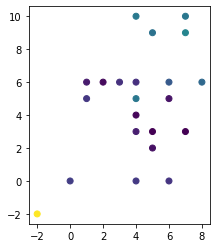

it 19:  -1866.321448535571


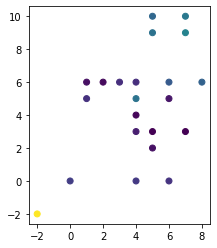

it 20:  -3064.961460506078


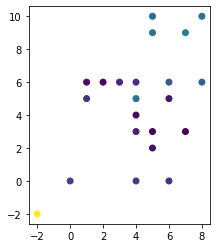

it 21:  -1071.7092595492722


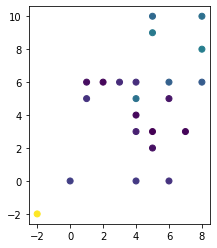

it 22:  -109.4038129231194


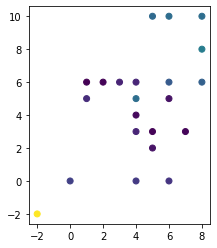

it 23:  -5020.302700408502


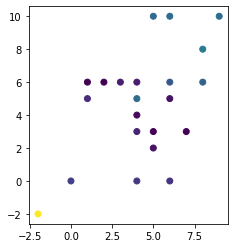

it 24:  -383.17289051556145


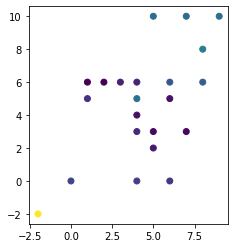

it 25:  -2215.1226353794045


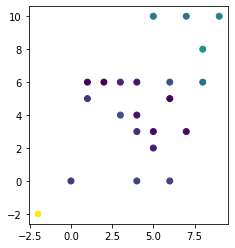

it 26:  -3492.1118502985337


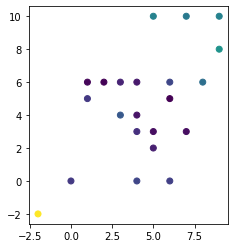

it 27:  -2.3406384190602694


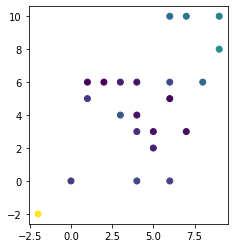

it 28:  -2563.7411563410133


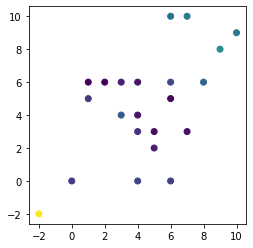

it 29:  -216.4388980816293


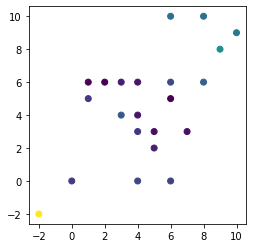

it 30:  -1145.5035671369114


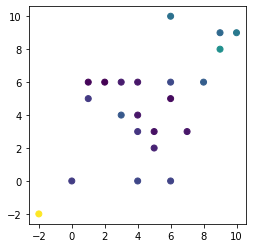

it 31:  -1031.861811634386


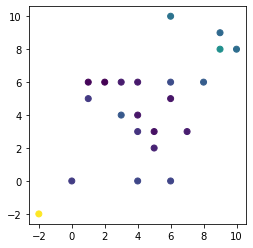

it 32:  -11.879562067450024


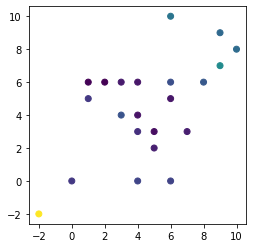

it 33:  -61.0638714407105


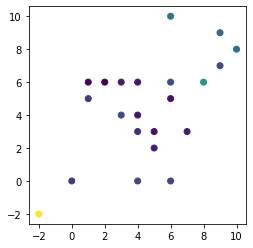

it 34:  -5069.067467492016


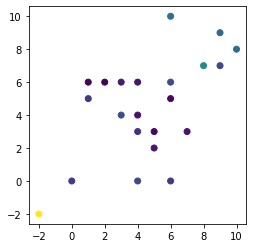

it 35:  -3308.4070761658368


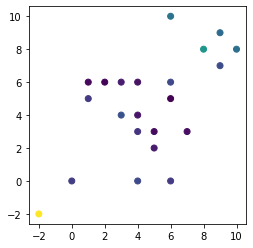

it 36:  -137.58757982286625


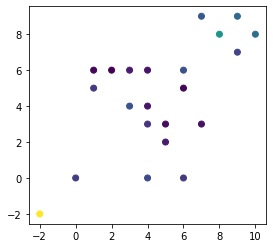

it 37:  -2400.7078218878014


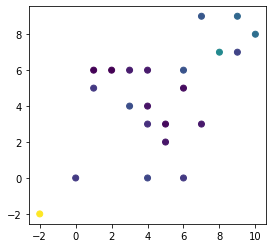

it 38:  -212.35912556992844


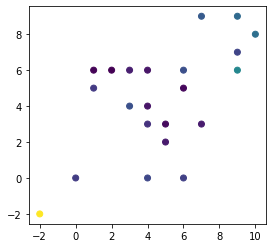

it 39:  -370.98681252624374


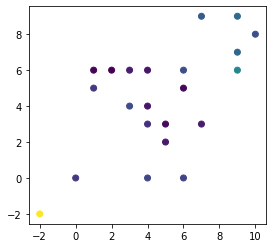

it 40:  -2126.372445024579


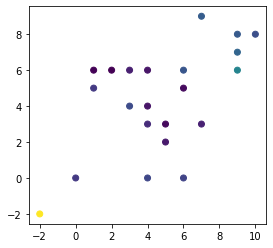

it 41:  -1111.2618606797187


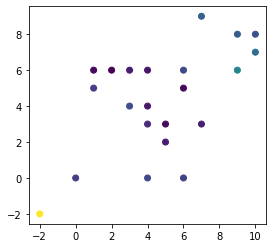

it 42:  -1338.0201835899497


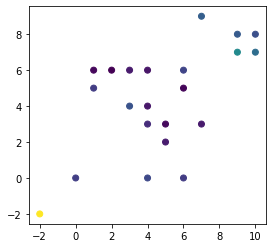

it 43:  -710.0051186033234


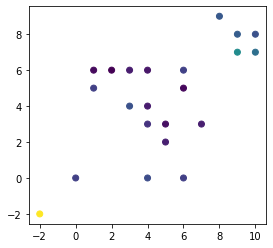

it 44:  -1538.0120158105565


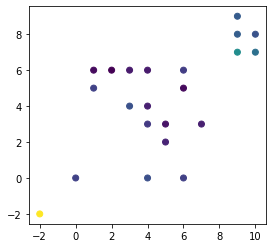

it 45:  -418.5334894969128


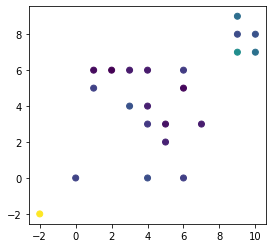

it 46:  -223.69805088598514


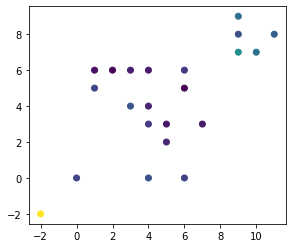

it 47:  -314.81354071124224


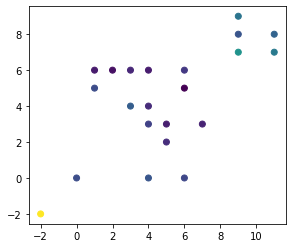

it 48:  -501.5203997110366


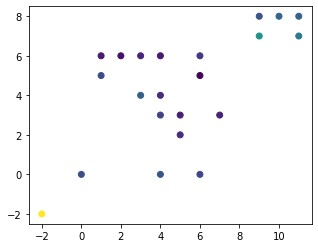

it 49:  -1476.6435070204898


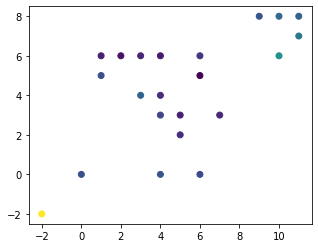

it 50:  -156.38801984515158


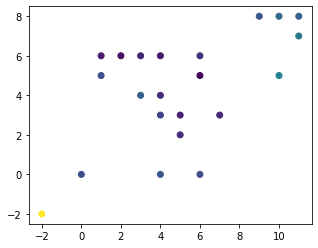

it 51:  -1061.0113469461212


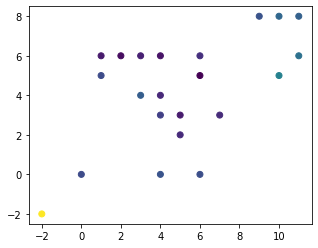

it 52:  -66.19084780997946


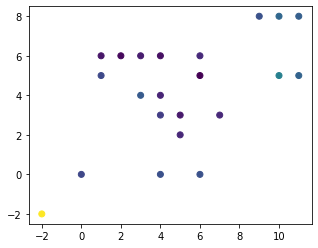

it 53:  -215.65942522790283


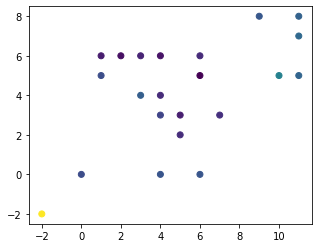

it 54:  -437.24009375230526


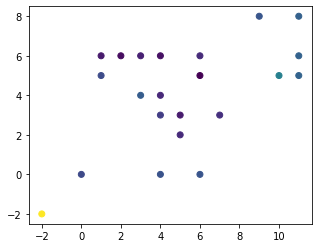

it 55:  -323.14820391108515


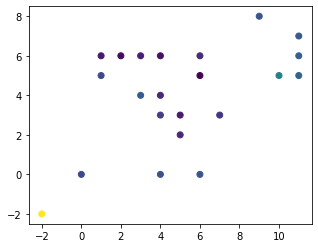

it 56:  -292.6816923774895


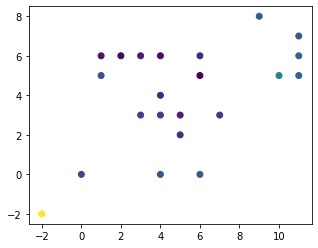

it 57:  -2453.2765918874065


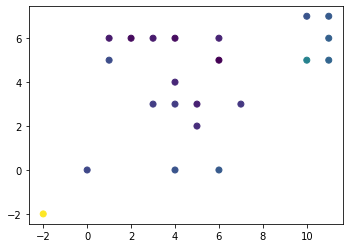

it 58:  -1388.4747674154933


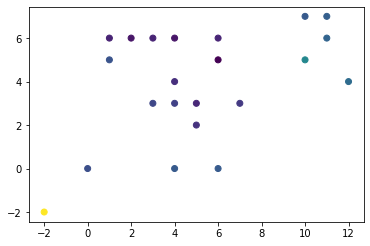

it 59:  -73.81471823400352


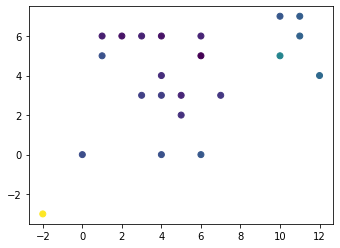

it 60:  -4.4147179704741575


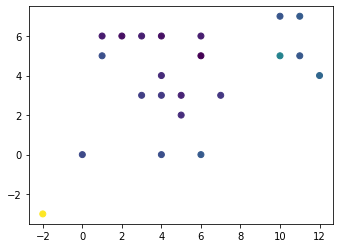

it 61:  -29.72602834412828


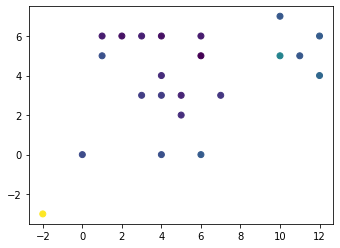

it 62:  -425.1884550046816


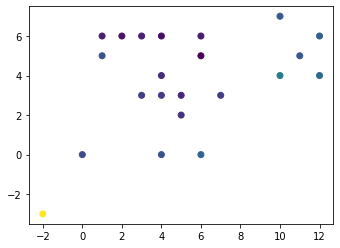

it 63:  -166.91562032522052


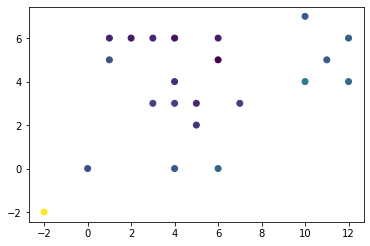

it 64:  -141.59216285278671


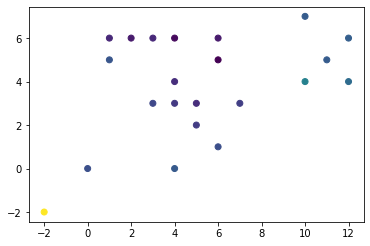

it 65:  -4594.097557382018


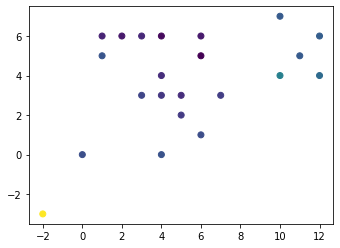

it 66:  -50.41258812326123


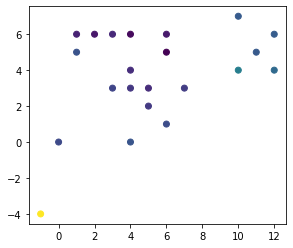

it 67:  -187.36719529906986


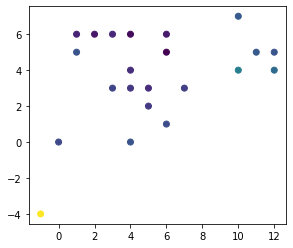

it 68:  -413.1092785364308


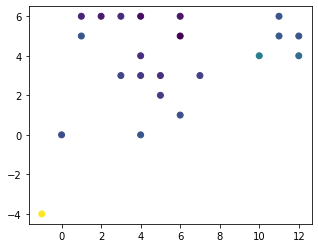

it 69:  -968.3809404147323


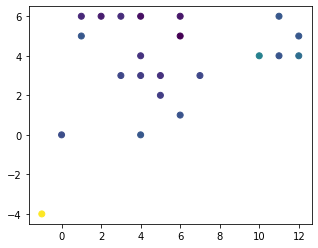

it 70:  -92.36658715817612


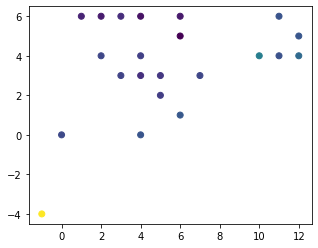

it 71:  -3363.059271997743


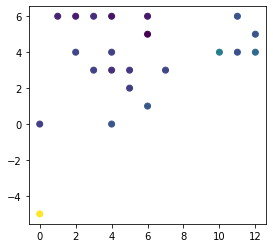

it 72:  -411.9649731499667


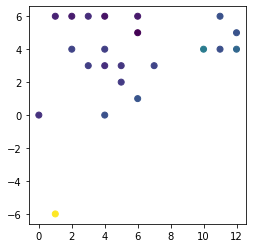

it 73:  -399.412276774412


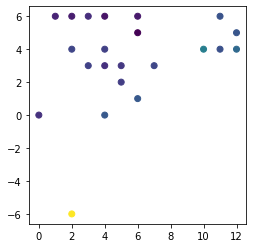

it 74:  -763.7857152364159


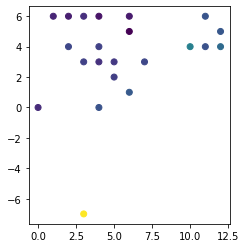

it 75:  -786.3921484414313


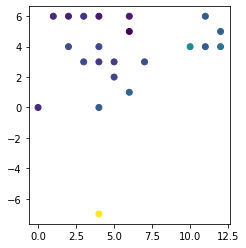

it 76:  -2333.603398369043


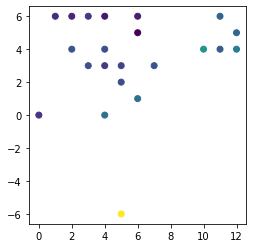

it 77:  -2005.031028046069


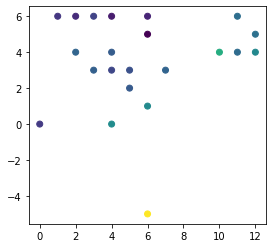

it 78:  -3185.274274522817


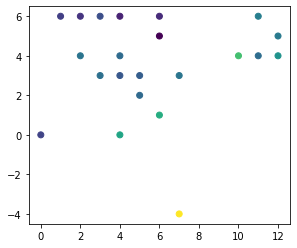

it 79:  -3457.212588573864


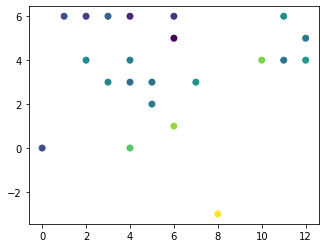

it 80:  -5002.037287175393


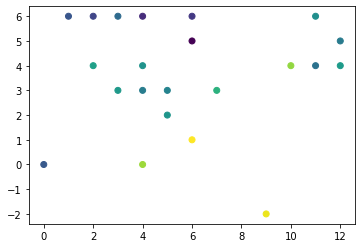

it 81:  -4536.364083686582


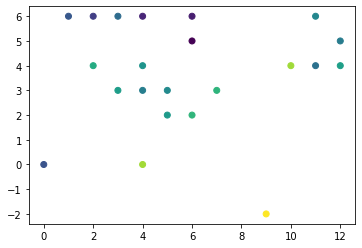

it 82:  -3585.8439224581525


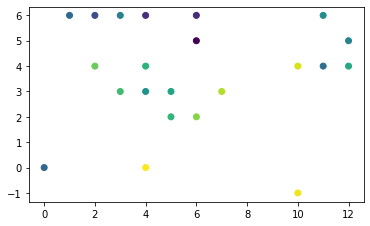

it 83:  -4816.270475797879


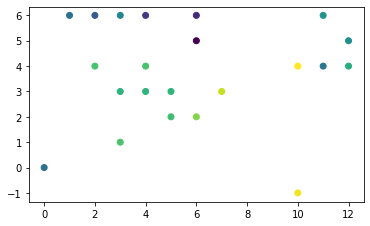

it 84:  -3415.849265157245


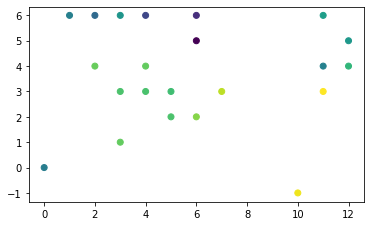

it 85:  -763.3248379332072


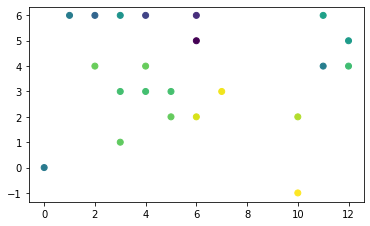

it 86:  -298.33292409486603


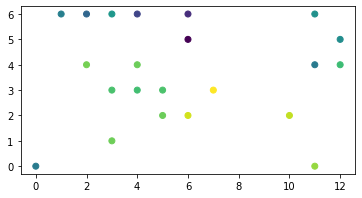

it 87:  -2450.7027597884007


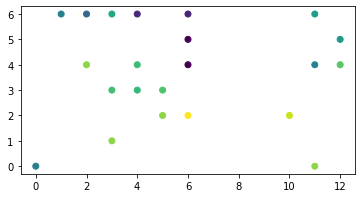

it 88:  -8821.492995189386


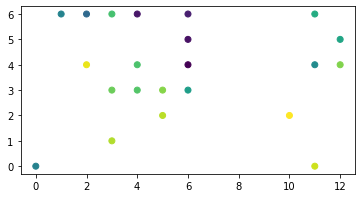

it 89:  -2754.2919641919143


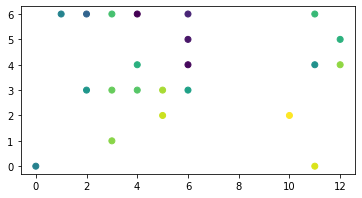

it 90:  -3992.067262923636


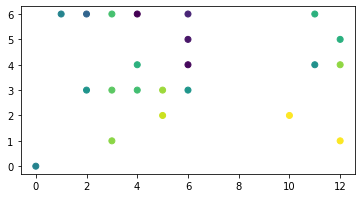

it 91:  -444.1626894920191


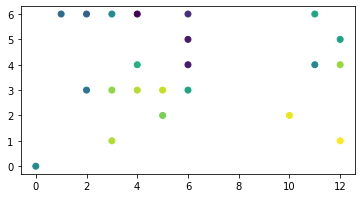

it 92:  -6321.119748205005


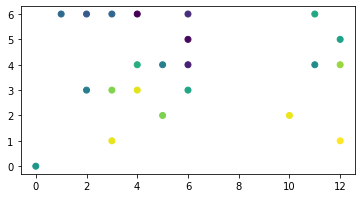

it 93:  -2909.012230942564


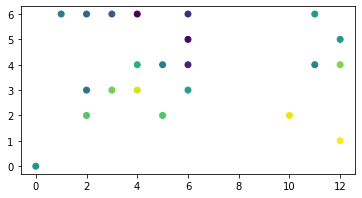

it 94:  -1488.9633330137585


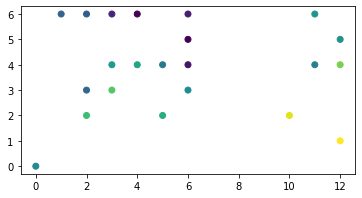

it 95:  -1927.322622740583


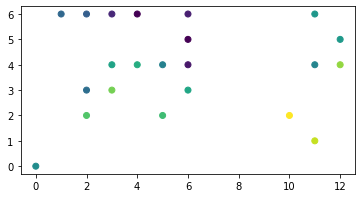

it 96:  -140.44488439099223


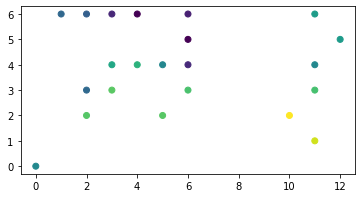

it 97:  -1101.868464216168


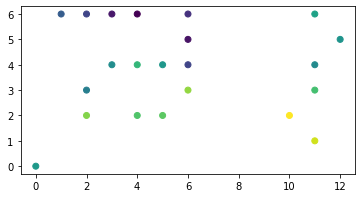

it 98:  -4851.106411928486


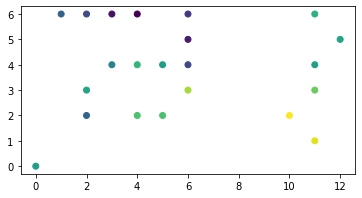

it 99:  -3052.488692270621


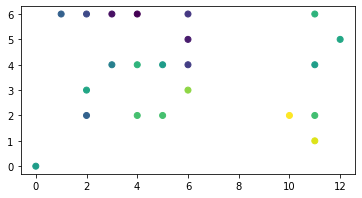

it 100:  -724.4051776181732


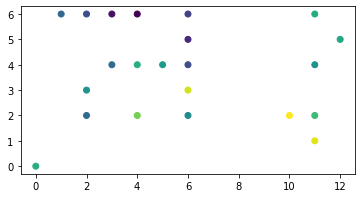

it 101:  -3784.3703409588343


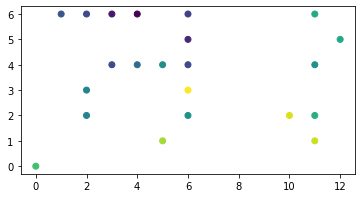

it 102:  -5032.7097160952835


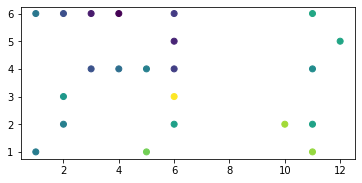

it 103:  -2093.1275325409515


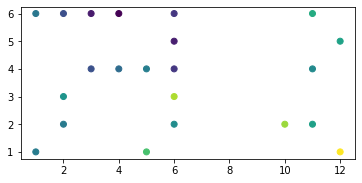

it 104:  -93.2119422423275


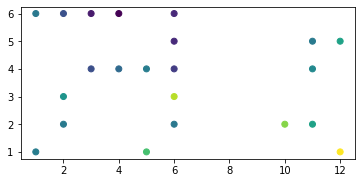

it 105:  -1339.88486268805


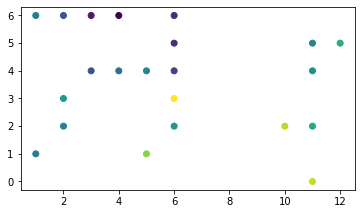

it 106:  -61.78587639286707


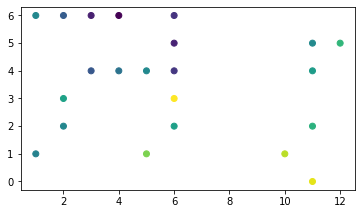

it 107:  -157.6558002987149


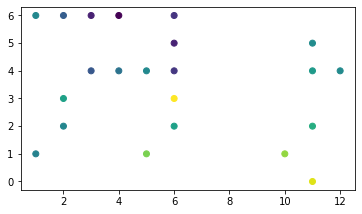

it 108:  -951.3441630967573


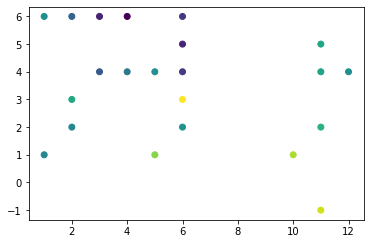

it 109:  -139.7193294986355


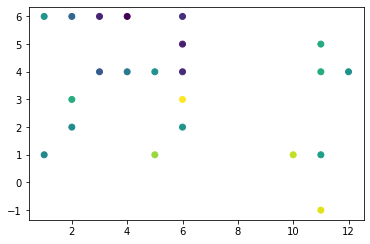

it 110:  -391.2327938056551


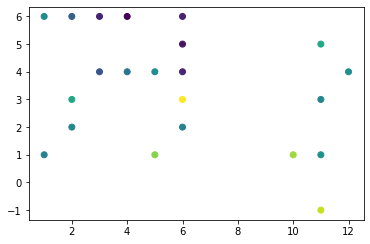

it 111:  -875.309428731518


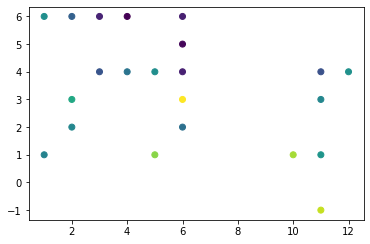

it 112:  -1712.5366373401775


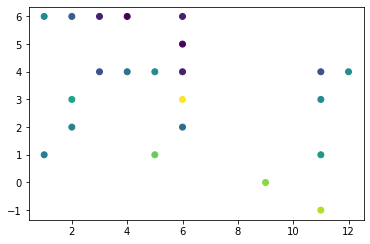

it 113:  -64.86512598348781


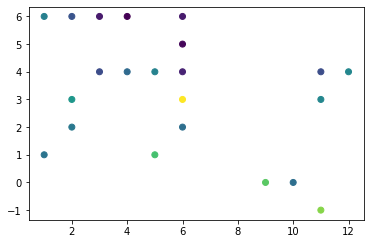

it 114:  -167.9912840135803


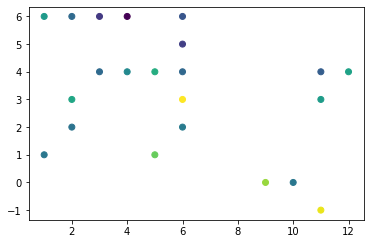

it 115:  -65.93165666075947


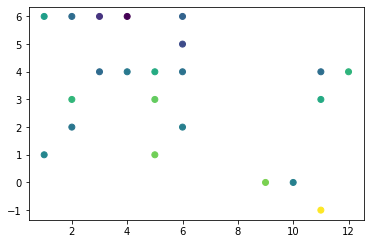

it 116:  -497.3130574640527


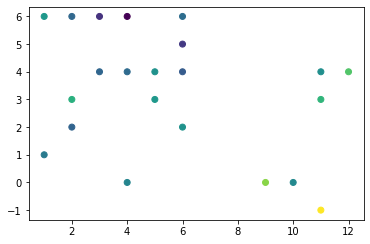

it 117:  -440.7894822651724


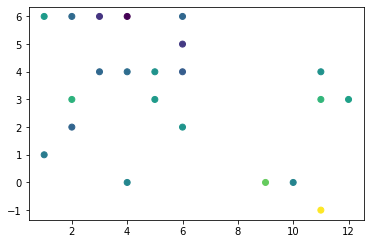

it 118:  -957.5648850715224


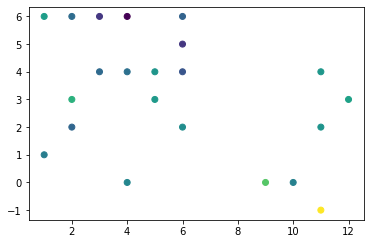

it 119:  -798.9622519528493


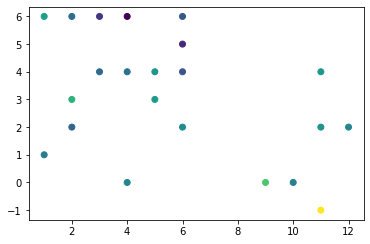

it 120:  -572.866124015316


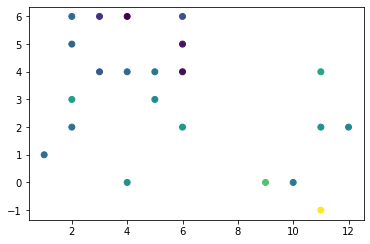

it 121:  -2112.4228901357565


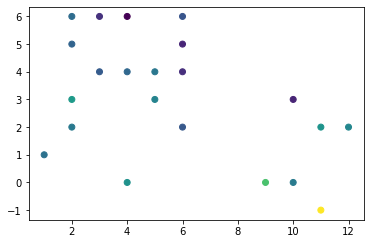

it 122:  -2091.0972881014022


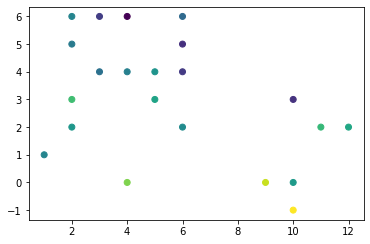

it 123:  -285.69051342381863


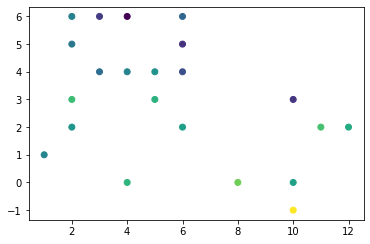

it 124:  -348.4951452877576


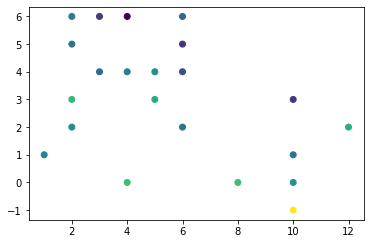

it 125:  -1576.388227802032


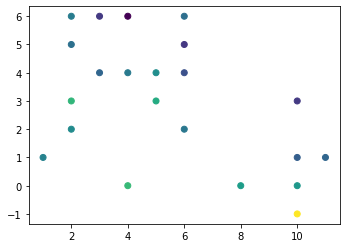

it 126:  -1514.816558075967


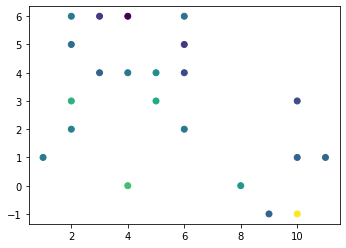

it 127:  -425.3502204005199


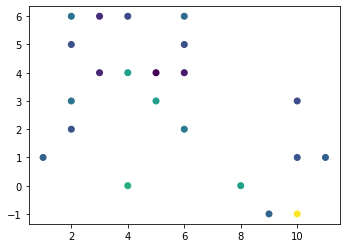

it 128:  -3864.8513941079873


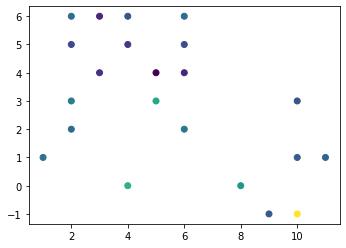

it 129:  -902.3625688087341


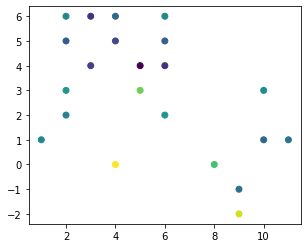

it 130:  -247.4676550939912


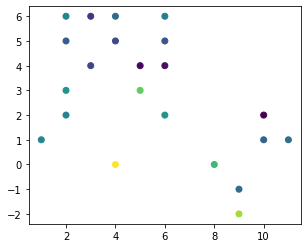

it 131:  -1430.3327349851606


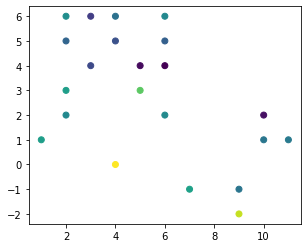

it 132:  -342.45202615475864


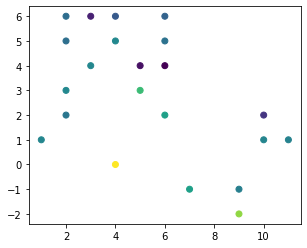

it 133:  -654.0512711198244


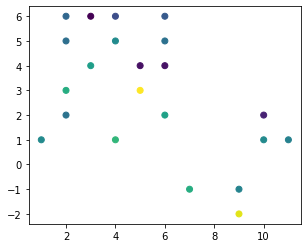

it 134:  -6.4582058035593946


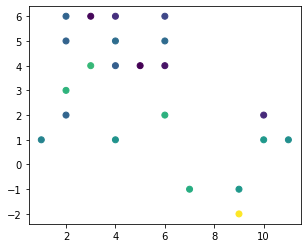

it 135:  -475.61315870699764


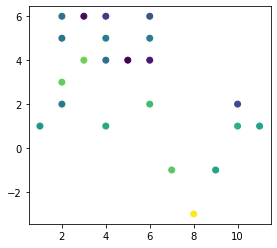

it 136:  -156.2925926401076


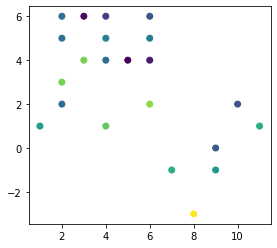

it 137:  -331.0963463260414


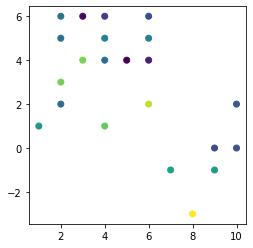

it 138:  -931.7645452572615


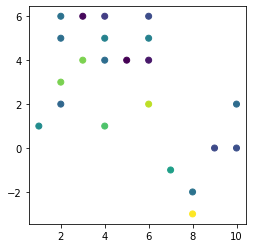

it 139:  -200.50785726768663


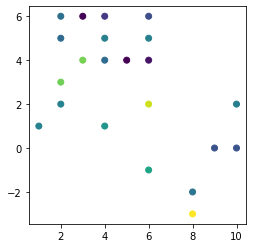

it 140:  -9.525532711501


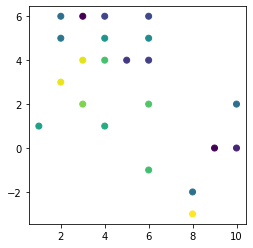

it 141:  -1194.70633460932


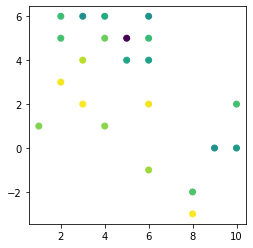

it 142:  -2871.4919616111


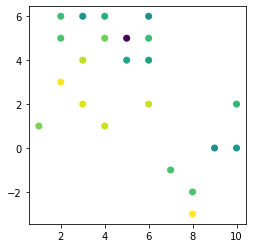

it 143:  -540.584630624202


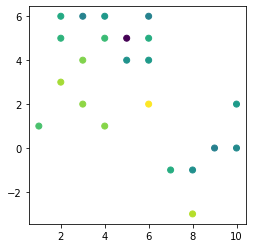

it 144:  -240.1360116982978


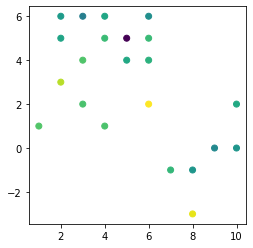

it 145:  -4365.171735266806


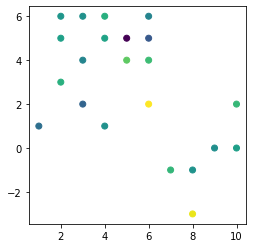

it 146:  -6457.833559141523


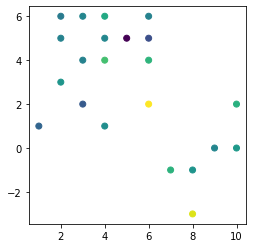

it 147:  -557.2594879530516


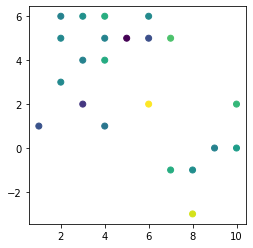

it 148:  -1193.4934980122343


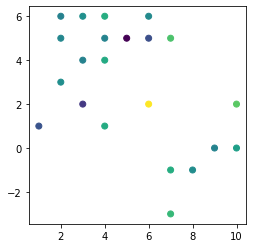

it 149:  -41.74740961104544


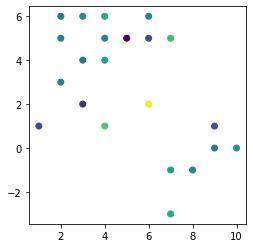

it 150:  -1145.2337490811042


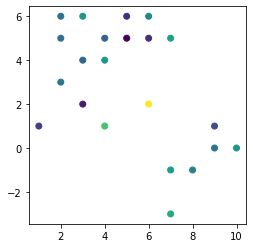

it 151:  -1510.4483549085126


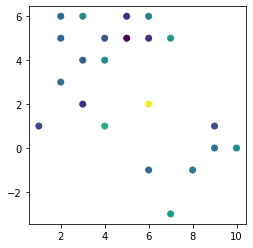

it 152:  -138.94885237469134


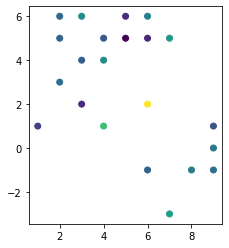

it 153:  -241.90147497738508


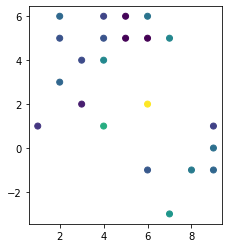

it 154:  -1149.9218556963096


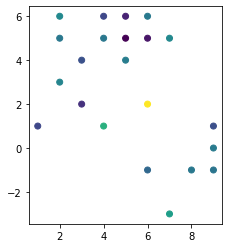

it 155:  -173.74581320410653


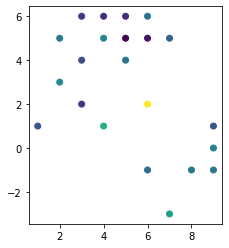

it 156:  -1799.126773776101


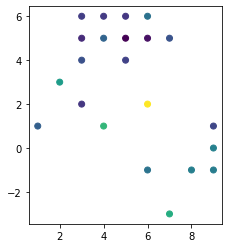

it 157:  -2870.9188790081535


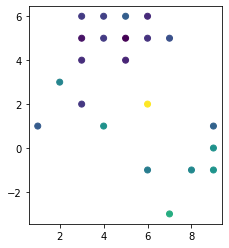

it 158:  -2483.7149719890294


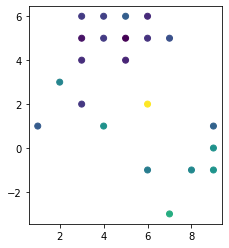

it 159:  0.0


In [149]:
c = 'y'
new_df = initial_df
it = 0
while c == 'y':
    
    old_df = new_df
    met_old = old_df['metric'].sum()
    
    d, new_df = do_iteration(old_df)
    new_df.plot(column='metric')
    plt.show()  
    
    met_new = new_df['metric'].sum()
    
    c = 'y' if d == False else 'n'
    c = 'n' if met_new > met_old else c
    
    print("it "+str(it)+":  "+str(met_new-met_old))
    it+=1
    
    

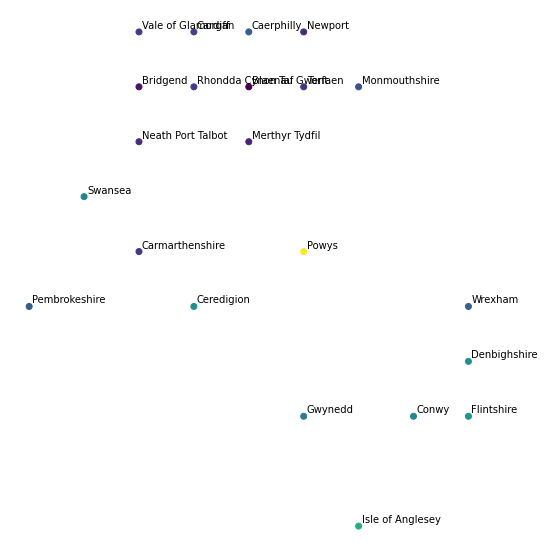

In [150]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

final = new_df[['code', 'geometry', 'metric']].merge(geodata[['LAD20NM', 'LAD20CD']], left_on='code', right_on='LAD20CD')

final.plot(column='metric', ax=ax)

for x, y, label in zip(final.geometry.x, final.geometry.y, final.LAD20NM):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [117]:
final

,code,geometry,metric,LAD20NM,LAD20CD
0,W06000001,POINT (4.000 8.000),990.500651,Isle of Anglesey,W06000001
1,W06000002,POINT (3.000 6.000),2660.139760,Gwynedd,W06000002
2,W06000003,POINT (4.000 7.000),2010.964848,Conwy,W06000003
3,W06000004,POINT (3.000 7.000),3911.406903,Denbighshire,W06000004
4,W06000005,POINT (2.000 8.000),2182.539347,Flintshire,W06000005
5,W06000006,POINT (2.000 7.000),3182.991715,Wrexham,W06000006
6,W06000008,POINT (3.000 4.000),2945.271986,Ceredigion,W06000008
7,W06000009,POINT (5.000 3.000),1870.134753,Pembrokeshire,W06000009
8,W06000010,POINT (4.000 4.000),3262.249519,Carmarthenshire,W06000010
9,W06000011,POINT (4.000 2.000),1916.414167,Swansea,W06000011


In [84]:
new_df['metric'].sum()

286199.5234828118

<AxesSubplot:>

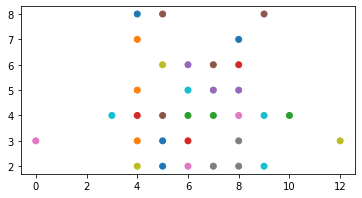

In [284]:
new_df.plot(column='code')

<AxesSubplot:>

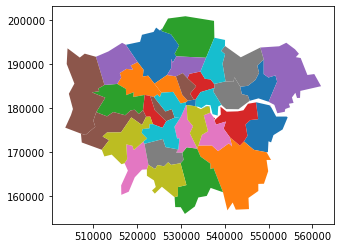

In [279]:
geodata.plot(column='LAD20CD')